# YamboRestart: a simple G0W0 run with error handling

This is the lowest-level workflow of the plugin. It runs a yambo calculation (p2y+yambo), involving automatic error handling.

The idea is to create a builder instance, which collects all the inputs needed for the simulation, then submit it by means of the aiida "submit" function.

In [15]:
from aiida import load_profile, orm
load_profile()

from aiida import orm

## 0 - A quantumespresso parent calculation

Before to run any yambo simulation, you need to have a quantumespresso nscf simulation. This can be done following the aiida-quantumespresso tutorial (contained in the AiiDA tutorials), or using one of the examples provided in the aiida-yambo plugin package (examples/plugin/...).

## 1 - Creation of YamboRestart instance using protocols

In this tutorial the creation of the builder, for a given workflow, is provided by means of the get_builder_from_protocol function.
This is, for now, just a way to automatically populated all the needed inputs, allowing the user to partially skip the long part of input definition as done in examples like the one contained in ``aiida_yambo/examples_hBN/workflows/yambo_restart.py``.


It is not meant to be an already tested set of default values as instead is done for the aiida-quantumespresso plugin. 

In [16]:
from aiida.plugins import WorkflowFactory

In [17]:
YamboRestart = WorkflowFactory('yambo.yambo.yamborestart')

## minimal inputs needed for protocols

In [18]:
options = {
    'yamboprecode_id':'p2y@lyra2',
    'yambocode_id':'yyambonicola@lyra2',
    'protocol':'fast',
    'parent_id':1762, #take your previously nscf id (pk)
}

In [19]:
#YamboRestart.get_builder_from_protocol??

In [21]:
builder = YamboRestart.get_builder_from_protocol(
            preprocessing_code = options['yamboprecode_id'],
            code = options['yambocode_id'],
            protocol=options['protocol'],
            overrides={},
            parent_folder=orm.load_node(options['parent_id']).outputs.remote_folder,
            RIM_v=False,           #this automatically set RIM_cut, if True
            RIM_W=False,           #this automatically set RIM_W, if True
            BG_term=False,         #this automatically set BG terminator, if True
)

Summary of the main inputs:
BndsRnXp = 200
GbndRnge = 200
NGsBlkXp = 6 Ry
FFTGvecs = 21 Ry



In [22]:
#You can also try different protocols:
    
YamboRestart.get_available_protocols()

{'fast': {'description': 'Under converged for most materials, but fast'},
 'moderate': {'description': 'Meta converged for most materials, higher computational cost than fast'},
 'precise': {'description': 'Converged for most materials, higher computational cost than moderate'},
 'bse_fast': {'description': 'Under converged for most materials, but fast'},
 'bse_moderate': {'description': 'Meta converged for most materials, higher computational cost than fast'},
 'bse_precise': {'description': 'Converged for most materials, higher computational cost than moderate'}}

Now, if you inspect the prepopulated inputs, you can see the default values respecting the imposed protocol:

In [23]:
builder.yambo.parameters.get_dict()

{'arguments': ['dipoles', 'ppa', 'HF_and_locXC', 'gw0'],
 'variables': {'Chimod': 'hartree',
  'DysSolver': 'n',
  'GTermKind': 'BG',
  'X_and_IO_nCPU_LinAlg_INV': [1, ''],
  'NGsBlkXp': [6, 'Ry'],
  'FFTGvecs': [21, 'Ry'],
  'BndsRnXp': [[1, 200], ''],
  'GbndRnge': [[1, 200], ''],
  'QPkrange': [[[1, 1, 32, 32]], '']}}

## 2 - Inputs completion

We have to include also the resources:

In [24]:
builder.yambo.metadata.options = {
    'max_wallclock_seconds': 60*60, # in seconds
    'resources': {
            "num_machines": 1, # nodes
            "num_mpiprocs_per_machine": 16, # MPI per nodes
            "num_cores_per_mpiproc": 1, # OPENMP
        },
    'prepend_text': u"export OMP_NUM_THREADS="+str(1), # if needed
    #'account':'project_name',
    'queue_name':'s3par',
    #'qos':'',
}

## 3 - Overrides

It is possible to modify the default inputs also during the builder creation phase, so not a posteriori. This can be done by using overrides:

In [25]:
overrides_yambo = {
        "yambo": {
            "parameters": {
                "arguments": [
                    "rim_cut",
                ],
                "variables": {
                    "NGsBlkXp": [4, "Ry"],
                },
            },
    'metadata':{
                    'options':{
    'max_wallclock_seconds': 60*60, # in seconds
    'resources': {
            "num_machines": 1, # nodes
            "num_mpiprocs_per_machine": 16, # MPI per nodes
            "num_cores_per_mpiproc": 1, # OPENMP
        },
    'prepend_text': u"export OMP_NUM_THREADS="+str(1), # if needed
    #'account':'project_name',
    'queue_name':'s3par',
    #'qos':'',
                    },
    },
        }
}

In [26]:
builder = YamboRestart.get_builder_from_protocol(
            preprocessing_code = options['yamboprecode_id'],
            code = options['yambocode_id'],
            protocol=options['protocol'],
            overrides=overrides_yambo,
            parent_folder=orm.load_node(options['parent_id']).outputs.remote_folder,
)

Summary of the main inputs:
BndsRnXp = 200
GbndRnge = 200
NGsBlkXp = 4 Ry
FFTGvecs = 21 Ry



In [27]:
builder.yambo.metadata.options

{'stash': {}, 'resources': {'num_machines': 1, 'num_cores_per_mpiproc': 1, 'num_mpiprocs_per_machine': 16}, 'max_wallclock_seconds': 3600, 'withmpi': True, 'prepend_text': 'export OMP_NUM_THREADS=1', 'queue_name': 's3par'}

In [28]:
builder.yambo.parameters.get_dict()

{'arguments': ['rim_cut', 'dipoles', 'HF_and_locXC', 'ppa', 'gw0'],
 'variables': {'Chimod': 'hartree',
  'DysSolver': 'n',
  'GTermKind': 'BG',
  'X_and_IO_nCPU_LinAlg_INV': [1, ''],
  'NGsBlkXp': [4, 'Ry'],
  'FFTGvecs': [21, 'Ry'],
  'BndsRnXp': [[1, 200], ''],
  'GbndRnge': [[1, 200], ''],
  'QPkrange': [[[1, 1, 32, 32]], '']}}

In [29]:
builder.yambo.metadata.options

{'stash': {}, 'resources': {'num_machines': 1, 'num_cores_per_mpiproc': 1, 'num_mpiprocs_per_machine': 16}, 'max_wallclock_seconds': 3600, 'withmpi': True, 'prepend_text': 'export OMP_NUM_THREADS=1', 'queue_name': 's3par'}

## 3 RUN

In [30]:
from aiida.engine import submit

In [31]:
run = None

In [32]:
if run:
    print('run is already running -> {}'.format(run.pk))
    print('sure that you want to run again?, if so, copy the else instruction in the cell below and run!')
else:
    run = submit(builder)

print(run)

uuid: 81eb8c10-51fa-49ed-ba39-57c00876f271 (pk: 1785) (aiida.workflows:yambo.yambo.yamborestart)


# Inspecting the outputs

suppose that your calculation completed successfully, then you can access the outputs via the output method of the run instance: 

In [34]:
run.is_finished_ok

True

In [35]:
run.outputs. #+TAB

SyntaxError: invalid syntax (708973465.py, line 1)

For example, we have the array_ndb ArrayData, which essentially contains the information on the run.output.QP_DB (which can also be accessed directly):

In [36]:
run.outputs.array_ndb.get_arraynames()

['E',
 'Z',
 'Eo',
 'Sc',
 'Sx',
 'Vxc',
 'Band',
 'Kpoint',
 'nbands',
 'nkpoints',
 'qp_table',
 'E_minus_Eo',
 'Kpoint_index']

In [37]:
E_dft = run.outputs.array_ndb.get_array('Eo') #Ha
E_qp = run.outputs.array_ndb.get_array('E')   #Ha

In [38]:
from matplotlib import pyplot as plt

In [39]:
from ase import units

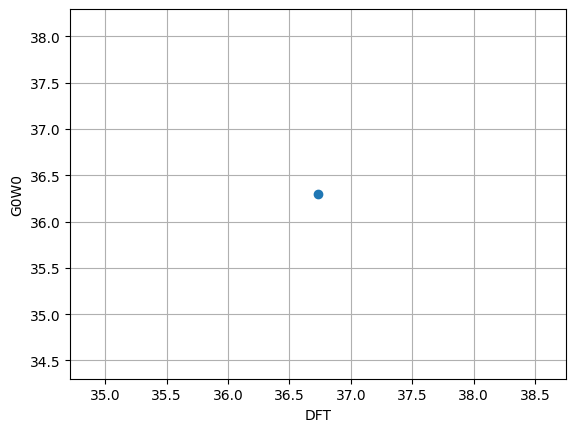

In [40]:
plt.plot(E_dft.real*units.Ha,E_qp.real*units.Ha,'o')
plt.ylabel('G0W0')
plt.xlabel('DFT')
plt.grid()

In [41]:
E_qp

array([1.3339528-0.01264847j], dtype=complex64)

In [42]:
run.outputs.output_parameters.get_dict()

{'errors': [],
 'timing': [' <---> P1: [01] MPI/OPENMP structure, Files & I/O Directories\n',
  ' <---> P1: [02] CORE Variables Setup\n',
  ' <---> P1: [03] Transferred momenta grid and indexing\n',
  ' <---> P1: [04] Dipoles\n',
  ' <03s> P1: [05] Dynamic Dielectric Matrix (PPA)\n',
  ' <10s> P1: [06] Local Exchange-Correlation + Non-Local Fock\n',
  ' <10s> P1: [07] Dyson equation: Newton solver\n',
  ' <10s> P1: [08] Timing Overview\n',
  ' <10s> P1: [09] Memory Overview\n',
  ' <10s> P1: [10] Game Over & Game summary\n'],
 'has_gpu': False,
 'memstats': [],
 'warnings': [],
 'Fermi(eV)': 5.025779,
 'game_over': True,
 'last_time': 10,
 'para_error': False,
 'time_error': False,
 'ns_db1_path': '/tmp/tmpgt4sj665',
 'memory_error': False,
 'p2y_completed': True,
 'yambo_version': '5.x',
 'requested_time': 3600,
 'last_time_units': 'seconds',
 'yambo_wrote_dbs': True,
 'corrupted_fragment': False,
 'X_par_allocation_error': False}

In [43]:
run.outputs.QP_db

<SinglefileData: uuid: dcaab36b-6fef-4795-8043-2616f90f01ec (pk: 1789)>

## Error handling in action: the case of walltime exhaustion

You can try the restaring mechanism by asking for a very small time for the simulation, in such a way that the first run will not be completed successfully. 
You can see, by inspecting the report of the run, that the workflow tries to submit other calculation by increasing the time requested.